# Dengesiz Veri Seti

Bir iş için sınıflandırma modeli yaratıyorsunuz ve bu modelin doğruluk değeri %95 çıkıyor. Her şey güzel. Modeliniz kullanılmaya başlanıyor ama başarısız olduğu, her zaman aynı sınıfı tahminlediği fark ediliyor. Veri setini tekrar incelediğinizde tespit edilemeyen sınıfın veri setindeki oranın %5 olduğunu görüyorsunuz. Yani modelinizin başarısızlığı dengesiz veri setinden (Imbalanced Dataset) kaynaklı.

Dengesiz veri seti sınıflandırma problemlerinde görülür ve sınıf dağılımlarının birbirine yakın olmadığı durumlarda ortaya çıkar. Problem çoğunluğa sahip sınıfın azınlık sınıfını domine etmesinden kaynaklanır. Oluşturulan model çoğunluğa sahip sınıfa yakınlık gösterir, bu da azınlık sınıfının kötü sınıflandırılmasına sebep olur.

Dengesiz veri setleriyle karşılaştığımızda doğru gözlem yapabilmek ve dengeyi sağlayabilmek için uygulayabileceğimiz çeşitli yöntemler vardır:

- Doğru Metrik Seçimi
  - Precision
  - Recall
  - F1-score
  - ROC Curve
  - AUC
- Resampling
  - Oversampling
     - Random Oversampling
     - SMOTE Oversampling
  - Undersampling
     - Random Undersampling
     - NearMiss Undersampling
     - Undersampling (Tomek links)
     - Undersampling (Cluster Centroids)
- Daha fazla veri toplamak
- Sınıflandırma modellerinde bulunan “class_weight” parametresi kullanılarak azınlık ve çoğunluk sınıflarından eşit şekilde öğrenebilen model yaratılması,
- Tek bir modele değil , diğer modellerdeki performanslara da bakılması,
- Daha farklı bir yaklaşım uygulanıp Anomaly detection veya Change detection yapmak

Dengesizlik içeren Credit Card Fraud Detection veri setini inceleyip, daha sonrasında bu dengesizlikle başa çıkabilmek için veri setine çeşitli yöntemler uygulayacağız.

## Veri Setinin İncelenmesi

Kredi kartı şirketlerinin dolandırıcılığı tespit etmeleri önemlidir, müşterilerine yanlış ücretlendirilme yapılmasını istemezler. 

Bu veri seti kullanılarak dolandırıcılık yapılmış kredi kartlarını tespit eden bir model oluşturulmak isteniliyor. 

Veri seti eylül 2013'te avrupada kredi kartıyla yapılan işlemlerden ve bu işlemlerin fraud(dolandırıcılık) ise 1 değilse 0 olarak etiketlenmesiyle oluşmuştur. Gizlilik nedeniyle arka plan bilgisi çok fazla bulunmuyor ve "Time","Amount" değişkeni haricinde diğer değişkenler PCA(Principal component analysis) ile dönüştürülmüştür. 

- "Time" : ilk işlem ile her işlem arasındaki saniye
- "Amount": maliyet 

ilk olarak veri setini okutup, boş değer olup olmadığını gözlemleyip, Class değişkenin dağılımına bakacağız. Daha sonrasında "Amount" ve "Time" değişkenini standartlaştırıyoruz. Veriyi hold out yöntemiyle ayırıp, sınıflandırma modeli olan logistic regression ile modeli oluşturuyoruz. Tek bir model üzerinden gideceğiz.

In [1]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report,f1_score,recall_score,roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc,rcParams
import itertools

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [3]:
# Veri setinin okutulması
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Veri setindeki değişken ve gözlem sayısı
print("Gözlem sayısı : " ,len(df))
print("Değişken sayısı : ", len(df.columns))

Gözlem sayısı :  284807
Değişken sayısı :  31


In [5]:
# veri setindeki değişkenlerin tiplerini ve boş değer içerip içermediğini gözlemlemek istiyoruz
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

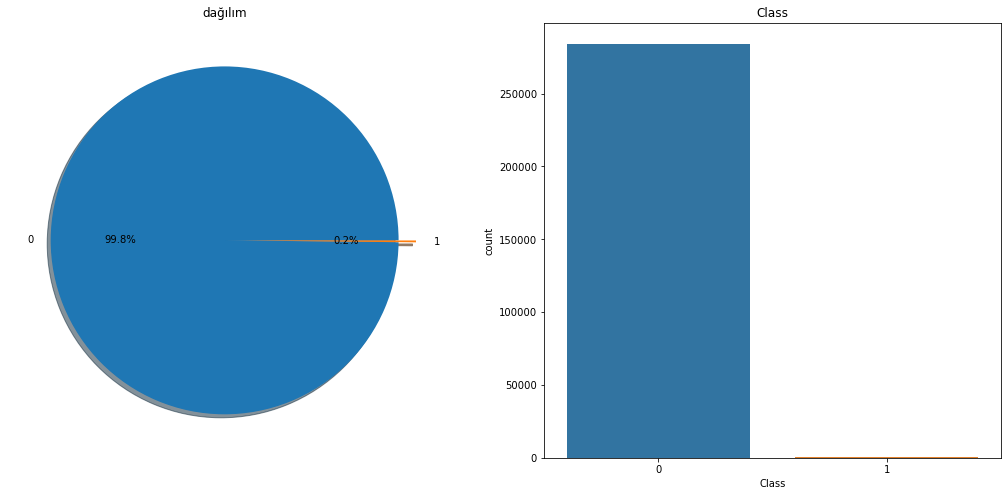

In [6]:
# 1 sınıfının veri setinde bulunma oranı %0.2, 0 sınıfının ise %99.8
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Class'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('dağılım')
ax[0].set_ylabel('')
sns.countplot('Class',data=df,ax=ax[1])
ax[1].set_title('Class')
plt.show()

In [7]:
# Time ve Amount değişkenlerini standartlaştırma
rob_scaler = RobustScaler()
df['Amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,0
1,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,0
2,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,0
3,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,0
4,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,0


In [8]:
# Hold out yöntemi uygulayıp veri setini eğitim ve test olarak ikiye ayırıyoruz.(%80,%20)
X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123456)

In [9]:
# modelin tanımlanıp, eğitilmesi ve başarı skoru
model = LogisticRegression(random_state=123456)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.3f"%(accuracy))

Accuracy: 0.999


**Accuracy** sistemde doğru olarak yapılan tahminlerin tüm tahminlere oranıdır.

Oluşturduğumuz modelin doğruluk skoru 0.999. Modelimiz mükemmel çalışıyor diyebiliriz, değil mi? 

Performansını incelemek için birde Confusion Matrix'ine bakalım.

## Confusion Matrix
Confusion Matrix, bir sınıflandırma modelinin gerçek değerlerinin test verisi üzerindeki performansını açıklamak için kullanılan bir tablodur.

Tahmini ve gerçek değerlerin 4 farklı kombinasyonunu içermektedir.

<img src="https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png" width="400px"/>

- True Positives (TP) : Pozitif tahmin edildi ve bu doğru.
- True Negative (TN) : Negatif tahmin edildi ve bu doğru.
- False Positive (FP) : Pozitif tahmin edildi ve bu yanlış.
- False Negative (FN) : Negatif tahmin edildi ve bu yanlış.

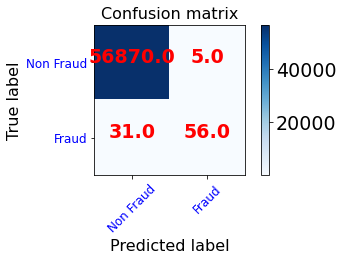

In [10]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.rcParams.update({'font.size': 19})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontdict={'size':'16'})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=12,color="blue")
    plt.yticks(tick_marks, classes,fontsize=12,color="blue")
    rc('font', weight='bold')
    fmt = '.1f'
    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")

    plt.ylabel('True label',fontdict={'size':'16'})
    plt.xlabel('Predicted label',fontdict={'size':'16'})
    plt.tight_layout()

plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=['Non Fraud','Fraud'],
                      title='Confusion matrix')

- Non Fraud sınıfı için 56870 (TP) doğru, 5 (FP) yanlış toplam 56875 tahmin yapılmış.

- Fraud sınıfı için 31 (FN) yanlış, 56 (TN) doğru toplam 87 tahmin yapılmış.

Model bize Fraud durumunu 0.99 doğrulukla tahmin edebildiğini söylüyor.Ama confusion Matrix'i incelediğimizde Fraud sınıfındaki yanlış tahminlerin oranı hayli yüksek. Çoğunluk sınıfını tahmin etmekte  başarılıyken, azınlık sınıfını tahmin etmede başarılı değildir. Yani model 0.99 oranla non-fraud sınıfını doğru tahmin etmekte.

Non Fraud sınıfına ait gözlem sayısının fraud sınıfına ait gözlem sayısından fazla olması, modelin Non Fraud sınıfını tahminlemede başarılı olmasına neden olmakta. 

Yaptığımız bu gözlem ile accuarcy score'un sınıflandırma modelleri için iyi bir performans ölçümü olmadığını söyleyebiliriz, özelliklede elimizdeki veri setindeki gibi dengesizlik içeriyorsa.

Veri setini inceledik,  dengesizlikle nasıl başa çıkıp model oluşturabiliceğimize, hangi yöntemlerin uygulanabileceğine ve performansını hangi metriklerle ölçebileceğimize bakabiliriz.

# Doğru Metrik Seçimi

Doğruluk değerinin (Accuracy Score) yeterli olmadığını gördük. Modelin performansını ölçmek için farklı metriklere bakmamız gerekiyor.

**Precision (Kesinlik):** Pozitif olarak tahmin edilenlerin ne kadarının gerçekte pozitif olduğunu gösterir. Eğer precision düşük ise çok sayıda hatalı pozitif olduğunu ifade eder.<img src="https://miro.medium.com/max/1104/1*5PvyyMvH5n42XICQrlXOzw.png"  width="300"/>

**Recall (Duyarlılık):** Pozitif olarak tahmin etmemiz gereken değerlerin ne kadarını pozitif tahmin ettiğimizi gösterir. Eğer recall düşük ise çok sayıda yanlış negatif olduğunu ifade eder. Mümkün olduğu kadar yüksek olmalıdır.<img src="https://lawtomated.com/wp-content/uploads/2019/10/Recall_1.png"  width="350"/>

**F1 score:** Düşük precison ve yüksek recall veya tam tersi durumda iki modeli karşılaştırmak güçtür. Karşılaştırılabilir bir hale getirmek F1 score'u
precision ve recall'u aynı anda ölçülmesine yardımcı olur. Precision ve Duyarlılık değerlerinin harmonik ortalamasını göstermektedir.<img src="https://lawtomated.com/wp-content/uploads/2019/10/F1-Score.png"  width="350"/>

Modelimiz için bu metrikleri inceleyelim.

**Sınıflandırma raporu**, ana sınıflandırma ölçütlerinin sınıf bazında temsilini gösterir.

In [10]:
#sınıflandırma raporu
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.92      0.64      0.76        87

    accuracy                           1.00     56962
   macro avg       0.96      0.82      0.88     56962
weighted avg       1.00      1.00      1.00     56962



**Precision** ölçüsünü herbir sınıf için inceleyelim. 

- 0 (non fraud )sınıfı için yapılan tahminlerden kaçının doğru olduğunu verir. Confusion matrix'ine bakıldığında 56870 + 31 = 56901 tane non fraud sınıfı tahmini yapılmış ve bunun 56870 tanesi doğru tahmin edilmiş. 0 sınıfı için Precision değeri 1'dir (56870 / 56901 )

- 1 (fraud) sınıfı için yapılan tahminlerden kaçının doğru olduğunu verir. Confusion matrix'ine bakıldığında 5 + 56 = 61 tane fraud sınıfı tahmini yapılmış ve bunun 56 tanesi doğru tahmin edilmiş. 0 sınıfı için Precision değeri 0.92'dir (56 / 61)

**Recall** ölçüsünü herbir sınıf için inceleyelim.

- 0(non fraud) sınıfı için tahmin etmemiz gereken değerlerin ne kadarını doğru tahmin ettiğimizi gösterir. 56870 + 5 = 56875 tane non fraud sınıfına ait gözlemimiz var ve bunların 56870 i doğru tahmin edilmiş. 0 sınıfı için recall değeri 56870 / 56875 = 1 'dir.

- 1(fraud) sınıfı için tahmin etmemiz gereken değerlerin ne kadarını doğru tahmin ettiğimizi gösterir. 31 + 56 = 87 tane fraud sınıfına ait gözlemimiz var ve bunların 56'si doğru tahmin edilmiş. 1 sınıfı için recall değeri 56 / 87 = 0.64 'dir.

Recall değerinlerine bakıldığında 1 sınıfın tahmin edilme başarısızlığını çok rahat görebiliyoruz.

**F1-score**'u da recall ve precision değerlerinin harmonik ortalamsını ifade ediyor.

**Support** ise sınıfların gerçek değerlerinin sayısını ifade etmekte. Ölçümlerin yapısal zayıflıklarını gösterebilir yani Sınıflar arasındaki gözlem sayısındaki dengesizliğin ölçümleri etkilediğini söyliyebiliriz.

#### ROC curve

ROC eğrisi , tüm sınıflandırma eşiklerinde bir sınıflandırma modelinin performansını gösteren bir grafiktir. Bu eğri iki parametreyi çizer:
    
- True Positive Rate : Recall

<img src="https://cdn-images-1.medium.com/max/265/1*_l7BcJqqNnIzcjzY0b7WGg.png"  width="200"/>


- False Positive Rate : Fraud'ı tespit etmedeki başarısızlık


<img src="https://miro.medium.com/max/506/1*YHYVVN_lu4_fhtGYyziC1w.png"  width="200"/>

Farklı sınıflandırma eşiklerinde gerçek pozitif oran ve yanlış pozitif oran eğrisidir. (0,0) ‘da başlar ve (1,1)’ de biter. İyi bir model, 0'dan 1'e hızla giden bir eğri üretir.

<img src="https://marlin-prod.literatumonline.com/cms/attachment/36cdb4ec-0c7d-48cb-9a4d-7cb463f8b7c3/gr1.jpg"  width="300"/>

 #### AUC (Area under the ROC curve)
ROC eğrisini tek bir sayı ile özetler. (0,0) 'dan (1,1)' e kadar tüm ROC eğrisinin altındaki iki boyutlu alanın tamamını ölçer. En iyi değer 1, en kötü değeri 0.5'dir.


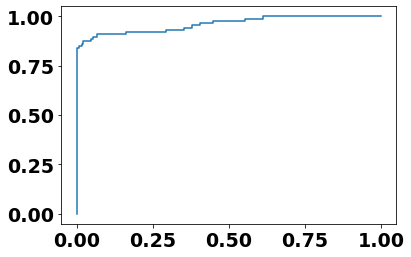

In [11]:
# Auc Roc Curve
def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr)
    plt.show()
    pass

generate_auc_roc_curve(model, X_test)

In [12]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC ROC Curve with Area Under the curve = %.3f"%auc)

AUC ROC Curve with Area Under the curve = 0.961


**Not :** ROC eğrisinin (AUC) altındaki alan, genel sınıflandırma performansını değerlendirir. AUC, bir sınıfa diğerine daha fazla önem vermediğinden, azınlık sınıfını iyi yansıtmamaktadır.

Dengesizliği gidermek için çeşitli yöntemleri veri setine uygulayalım.

#### NOT: Yöntemler eğitim setine uygulanmalıdır. Test setine uygulanırsa doğru değerlendirme yapılamaz.

# Resampling

Yeniden örnekleme(Resampling), azınlık sınıfına yeni örnekler ekleyerek veya çoğunluk sınıfından örnekler çıkarılarak veri setinin daha dengeli hale getirilmesidir.<img src="https://miro.medium.com/max/2956/1*YfQc_bSmbrlgD9gVd6f99A.png"  width="600"/>

## Oversampling
Azınlık sınıfına ait örneklerin kopyalanmasıyla veri setini dengeler.

**Random Oversampling:** 
- Azınlık sınıfından rastgele seçilen örneklerin eklenmesiyle veri setinin dengelenmesidir. 
- Veri setiniz küçükse bu teknik kullanılabilinir. 
- Overfitting’e neden olabilir.

RandomOverSampler metodu sampling_strategy argümanını almakta, sampling_stratefy='minority' dendiğinde azınlık sınıfının sayısını çoğunluk sınıfının sayısa eşitleyecek şekilde artırır.

Bu argümana float bir değerde girebiliriz. Örneğin azınlık sınıfımızın sayısı 1000, çoğunluk sınıfının sayısı 100 olsun. sampling_stratefy = 0.5 dersek, azınlık sınıfının sayısı 500 olucak şekilde ekleme yapılacaktır.

In [13]:
# random oversampling önce eğitim setindeki sınıf sayısı
y_train.value_counts()

0    227440
1       405
Name: Class, dtype: int64

In [14]:
# RandomOver Sampling uygulanması (Eğitim setine uygulanıyor)
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_randomover, y_randomover = oversample.fit_resample(X_train, y_train)

In [15]:
# random oversampling den sonra eğitim setinin sınıf sayısı
y_randomover.value_counts()

1    227440
0    227440
Name: Class, dtype: int64

In [16]:
# modelin eğitilmesi ve başarı oranı
model.fit(X_randomover, y_randomover)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.3f%%" % (accuracy))

Accuracy: 0.977%


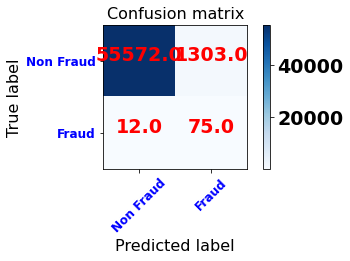

In [17]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=['Non Fraud','Fraud'],
                      title='Confusion matrix')

In [18]:
#sınıflandırma raporu
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56875
           1       0.05      0.86      0.10        87

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962



Random Oversampling uygulandıktan sonra eğitilen modelin doğruluk değeri 0.97'dır, düşüş gözlenmekte. Confusion Matrix ve Sınıflandırma raporuna bakıldığında, tahmin edilen fraud sınıflarının yanlış çıkma oranı yüksek görünüyor, bu da 1 sınıfın precision değerini düşürmüş durumda. Ama 1 sınıfının recall değerinde de bir yükseliş var, modelin fraud sınıfını doğru tahmin etme oranı artmıştır. İlk modele göre Non fraud sınıfının tahmin edilme başarısı düşmüş durumda ama fraud sınıfının doğru tahmin edilmesindeki yükselme randomoversampling yapıldıktan sonra oluşturulmuş modeli tercih etmemizde büyük bir etken.

**SMOTE Oversampling:**

Overfitting’i önlemek için azınlık sınıfından sentetik örnekler oluşturulması.

- Önce azınlık sınıfından rastgele bir örnek seçilir.
- Daha sonra bu örnek için en yakın komşulardan k tanesi bulunur.
- k en yakın komşulardan biri rastgele seçilir ve azınlık sınıfından rastgele seçilen örnekle birleştirilip özellik uzayında bir çizgi parçası oluşturarak sentetik örnek oluşturulur.

In [19]:
# smote dan önce eğitim setindeki sınıf sayısı
y_train.value_counts()

0    227440
1       405
Name: Class, dtype: int64

In [20]:
# Smote uygulanması (Eğitim setine uygulanıyor)
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X_train, y_train)

In [21]:
# smote dan sonra eğitim setinin sınıf sayısı
y_smote.value_counts()

1    227440
0    227440
Name: Class, dtype: int64

In [22]:
# modelin eğitilmesi ve başarı oranı
model.fit(X_smote, y_smote)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.3f%%" % (accuracy))

Accuracy: 0.975%


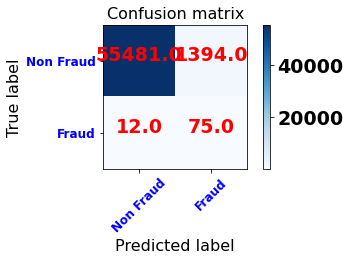

In [23]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=['Non Fraud','Fraud'],
                      title='Confusion matrix')

In [24]:
#sınıflandırma raporu
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56875
           1       0.05      0.86      0.10        87

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.54     56962
weighted avg       1.00      0.98      0.99     56962



## Undersampling

Çoğunluk sınıfına ait örneklerin çıkarılmasıyla veri setini dengeleme tekniğidir. Büyük veri setine sahip olunduğunda kullanılabilir. Elimizdeki veri seti büyük olmadığı için verimli sonuçlar alınmayacaktır. Ama yöntemleri açıklayıp  bazılarının nasıl uygulanabiliceğini göstereceğim. 

**Random Undersampling:** 

- Çıkarılan örnekler rastgele seçilir. 
- Büyük veri setine sahipseniz bu tekniği kullanabilirsiniz. 
- Rastgele seçimden dolayı bilgi kaybı yaşanabilir.

In [25]:
# random undersampling den önce eğitim setindeki sınıf sayısı
y_train.value_counts()

0    227440
1       405
Name: Class, dtype: int64

In [26]:
from imblearn.under_sampling import RandomUnderSampler
# transform the dataset
ranUnSample = RandomUnderSampler()
X_ranUnSample, y_ranUnSample = ranUnSample.fit_resample(X_train, y_train)

In [27]:
# Random undersampling sonra
y_ranUnSample.value_counts()

1    405
0    405
Name: Class, dtype: int64

**NearMiss Undersampling:**
- Bilgi kaybını önler. 
- KNN algoritmasına dayanır. 
- Çoğunluk sınıfına ait örneklerin azınlık sınıfına ait örneklerle olan uzaklığı hesaplanır. 
- Belirtilen k değerine göre uzaklığı kısa olan örnekler korunur.

**Undersampling (Tomek links):** 

Farklı sınıflara ait en yakın iki örneğin arasındaki çoğunluk sınıfının örnekleri kaldırılarak, iki sınıf arasındaki boşluk arttırılır.

**Undersampling (Cluster Centroids):** 

Önemsiz örneklerin veri setinden çıkarılmasıdır.Örneğin önemli veya önemsiz olduğu kümelemeyle belirlenir.

Undersampling ve Oversampling tekniklerinin bir araya gelmesiyle daha dengeli veri setleri oluşturulabilinir.

### Diğer Yöntemler

- Daha fazla veri toplamak,
- Sınıflandırma modellerinde bulunan “class_weight” parametresi kullanılarak azınlık ve çoğunluk sınıflarından eşit şekilde öğrenebilen model yaratılması,
- Tek bir modele değil , diğer modellerdeki performanslara da bakılması,
- Daha farklı bir yaklaşım uygulanıp Anomaly detection veya Change detection yapmak

gibi yöntemlerle de dengesiz veri setiyle başa çıkılır.

Hangi yöntemin en iyi sonuç vereceği elimizdeki veri setine bağlıdır. Yöntemler denenerek veri setine en uygun olanın seçilmesi en iyi sonucu sağlar diyebiliriz.

**REFERANS**
- https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
- https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
- https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
- https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/